# Import

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import random
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:

import os
import torch
import numpy as np
from torch import nn
from torch import Tensor
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from typing import Tuple, Union, List
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch
from torch import nn, einsum
import torchvision.transforms.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee','no-latex'])

# Set up env

In [3]:
torch.cuda.is_available()

True

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Load dataset

In [ ]:
class NPZDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  
        self.transform = transform  
        self.classes = ['no', 'sphere', 'vort']  
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}  
        self.samples = self._load_samples()  
    def _load_samples(self):
        samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)  
            for file_name in os.listdir(cls_dir):
                if file_name.endswith('.npy'):  
                    file_path = os.path.join(cls_dir, file_name)
                    samples.append((file_path, self.class_to_idx[cls_name]))
        return samples

    def __len__(self):
        return len(self.samples)  

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]  
        data = np.load(file_path)  
        data = torch.from_numpy(data).float()  
        if self.transform:
            data = self.transform(data)  
        return data, label  

In [ ]:
train_dir = "dataset/train/"  
val_dir = "dataset/val/"   

In [7]:
# Categories to preview
categories = ['no', 'sphere', 'vort']
num_images_per_class = 3  # Number of images to show per class

# Set up the subplot grid: 3 rows (one per class), 3 columns (images per class)
fig, axes = plt.subplots(nrows=len(categories), ncols=num_images_per_class, figsize=(15, 5 * len(categories)))

# Loop through each category and display images
for i, category in enumerate(categories):
    # Get the list of .npy files for this category
    category_dir = os.path.join(train_dir, category)
    image_files = [f for f in os.listdir(category_dir) if f.endswith('.npy')]
    
    # Select the first `num_images_per_class` files (or fewer if not enough files)
    image_files = image_files[:min(num_images_per_class, len(image_files))]
    
    # Load and display each image
    for j, image_file in enumerate(image_files):
        # Load the .npy file
        file_path = os.path.join(category_dir, image_file)
        image_data = np.load(file_path)  # Shape: (1, 150, 150)
        image_2d = image_data[0]  # Shape: (150, 150)
        
        # Plot the image
        ax = axes[i, j]
        ax.imshow(image_2d, cmap='gray')
        ax.set_title(f"{category} Sample {j+1}")
        ax.axis('off')
        
        # Print shape info for the first image in each category
        if j == 0:
            print(f"Category: {category}")
            print(f"Sample file: {file_path}")
            print(f"Image shape: {image_data.shape}")
            print(f"Adjusted image shape: {image_2d.shape}\n")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Category: no
Sample file: dataset/train/no/531.npy
Image shape: (1, 150, 150)
Adjusted image shape: (150, 150)

Category: sphere
Sample file: dataset/train/sphere/531.npy
Image shape: (1, 150, 150)
Adjusted image shape: (150, 150)

Category: vort
Sample file: dataset/train/vort/531.npy
Image shape: (1, 150, 150)
Adjusted image shape: (150, 150)



In [8]:
transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.Lambda(lambda x: x.rot90(random.randint(0, 3), [1, 2])), 
    # transforms.Lambda(lambda x: x / x.max()),
    transforms.Lambda(lambda x: x.float())  # Ensure float type
])

In [9]:
# Load full train and val datasets
full_train_dataset = NPZDataset(root_dir=train_dir, transform=transform)
val_dataset = NPZDataset(root_dir=val_dir, transform=None)

In [10]:
# Split train into 90% train and 10% test
train_size = int(0.9 * len(full_train_dataset))
test_size = len(full_train_dataset) - train_size
train_dataset, test_dataset = random_split(full_train_dataset, [train_size, test_size])

In [11]:
batch_size = 32

In [12]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check sizes
print(f"Full train dataset size: {len(full_train_dataset)}")
print(f"Train split size: {len(train_dataset)} (90%)")
print(f"Test split size: {len(test_dataset)} (10%)")
print(f"Validation size: {len(val_dataset)}")

Full train dataset size: 30000
Train split size: 27000 (90%)
Test split size: 3000 (10%)
Validation size: 7500


In [37]:
checkpoint_dir = "/workspace_2/checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)
epochloss_dir = "/workspace_2/epoch_loss/"
os.makedirs(epochloss_dir, exist_ok=True)

# Basic blocks

In [38]:
class ShiftPatchTokenizer(nn.Module):
    def __init__(self, image_size, embedding_size, patch_size, num_channels, translation_mode, device='cpu'):
        super(ShiftPatchTokenizer, self).__init__()

        self.image_size = image_size
        self.embedding_size = embedding_size  # size of the features of each patch
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.translation_mode = translation_mode
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        if self.image_size % self.patch_size != 0:
            raise ValueError("The image size must be divisible by the patch size")
        
        self.num_patches = (self.image_size // self.patch_size) ** 2

        self.num_translations = 4
        self.total_channels = self.num_channels * (1 + self.num_translations)

        self.tokenizer = nn.Conv2d(in_channels=self.total_channels,
                                   out_channels=self.embedding_size,
                                   kernel_size=(self.patch_size, self.patch_size),
                                   stride=(self.patch_size, self.patch_size))

        self.patch_width, self.patch_height = (patch_size, patch_size)
        self.shift_value_x, self.shift_value_y = (self.patch_width // 2, self.patch_height // 2)

        # This will convert the shape of image from I x I x C to self.num_patch(in square) x embedding_size
        # Now the class embeddings
        self.class_embedding = nn.Parameter(torch.zeros(1, 1, self.embedding_size))

        # Now creating the learnable parameter for the positional encoding
        self.positional = nn.Parameter(torch.zeros(1, self.num_patches + 1, self.embedding_size))

    def translation(self, image, delta_x, delta_y):
        trans_image = F.affine(img=image,
                               angle=0,
                               translate=(delta_x, delta_y),
                               scale=1,
                               shear=0)
        trans_image = trans_image.to(self.device)
        return trans_image
    def get_num_patches(self):
        return self.num_patches
    
    def forward(self, image):
        image = image.to(self.device)
        batch = image.shape[0]

        if self.translation_mode == "diagonal":
            shift_left_up = self.translation(image, -self.shift_value_x, -self.shift_value_y)
            shift_right_up = self.translation(image, self.shift_value_x, -self.shift_value_y)
            shift_left_down = self.translation(image, -self.shift_value_x, self.shift_value_y)
            shift_right_down = self.translation(image, self.shift_value_x, self.shift_value_y)

            # Concatenate the image + all the shifts
            patched_images = torch.cat((image, shift_left_up, shift_right_up, shift_left_down, shift_right_down), dim=1)

        elif self.translation_mode == "rectangular":
            shift_down = self.translation(image, 0, self.shift_value_y)
            shift_up = self.translation(image, 0, -self.shift_value_y)
            shift_left = self.translation(image, -self.shift_value_x, 0)
            shift_right = self.translation(image, self.shift_value_x, 0)

            # Concatenate the image + all the shifts
            patched_images = torch.cat((image, shift_down, shift_up, shift_left, shift_right), dim=1)
        
        else:
            raise ValueError("Invalid translation_mode")

        # Projection of the images to get the embeddings of all the patches so we have the shape batch, (height/patch_size), (width/patch_size), embedding_size
        projected_embeddings = self.tokenizer(patched_images)
        #print(projected_embeddings.shape)
        patches = projected_embeddings.flatten(2).transpose(1, 2)

        # The new shape of patches is batch, num_patches, embedding_size
        patches = patches.to(self.device)
        
        # Concatenating the class embeddings
        #print(patches.shape)
        class_tokens = self.class_embedding.expand(batch, -1, -1)
        patches = torch.cat((class_tokens, patches), dim=1)

        # Adding the positional encodings
        positional_patches = patches + self.positional

        return positional_patches

In [39]:
"""TESTING THE SHIFTED PATCH TOKENIZER """
tokenizer = ShiftPatchTokenizer(image_size=64, embedding_size=140, patch_size=32, num_channels=1, translation_mode="rectangular", device="cpu")
input_tensor = torch.randn(64, 1, 64, 64).to("cuda")
output = tokenizer(input_tensor)
print(output.shape)  # Expected output shape: (32, num_patches + 1, embedding_size)

torch.Size([64, 5, 140])


In [40]:
class MultiLocallySelfAttention(nn.Module):
    """This is a special form of self attention where the intra self-attention 
    calculation is not calculated and the attention calculation is not done 
    from itself it is done by assigning a large weight for the inter-token
    attention calculation and zero for the attention calculation between 
    the tokens itself for this an attention mask is calculated with False 
    on the diagonal and True on the else where. 
    like this 
       [[ True, False, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [False, False, False,  True]] 
    """
    def __init__(self, embedding_dim, num_heads, num_patches, device, dropout=0.1):
        super(MultiLocallySelfAttention, self).__init__()  # corrected super() call
        
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_patches = num_patches
        self.device = device
        self.dropout = dropout
        
        # Initialize the attention mask
        #self.attention_mask = torch.ones(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool)
        #self.attention_mask = self.attention_mask.triu(1) + self.attention_mask.tril(-1)
        #self.attention_mask = self.attention_mask.to(self.device)
        self.attention_mask = torch.eye(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool, requires_grad=False)
        self.attention_mask = self.attention_mask.to(device)

        # Initializing the multi-head self-attention layer
        self.mha = nn.MultiheadAttention(self.embedding_dim, self.num_heads, dropout=self.dropout, batch_first=True)
        
    def forward(self, key, query, value):
        x, _ = self.mha(query, key, value, attn_mask=self.attention_mask)
        return x

# FeedForwardBlock

In [41]:
class FeedForwardBlock(nn.Module):
    """
    This is a FeedForward block with structure like:
    Linear -> Activation Function -> Dropout -> Linear... (repeated for num_hidden_layers)
    
    This block is designed for regression, binary classification, or multi-class classification tasks.
    """
    def __init__(self,
                 in_dim: int,
                 out_dim: int,
                 hidden_dim: int,
                 num_hidden_layers: int,
                 activation_function: nn.Module,
                 task_type: str,
                 dropout: float = 0.1
                ):
        super(FeedForwardBlock, self).__init__()  # corrected super() call
        
        self.feed_list = nn.ModuleList()
        self.feed_list.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))  # add initial linear layer
        self.feed_list.append(activation_function())  # add activation function
        self.feed_list.append(nn.Dropout(dropout))  # add dropout layer
        
        # add hidden layers
        for _ in range(num_hidden_layers):
            self.feed_list.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
            self.feed_list.append(activation_function())
            self.feed_list.append(nn.Dropout(dropout))
        
        # determine final activation layer based on task type
        if task_type == "regression":
            self.final_activation_layer = nn.Identity()
        elif task_type == "binary":
            if out_dim != 1:
                raise ValueError("For binary classification, out_dim should be 1.")
            self.final_activation_layer = nn.Sigmoid()
        elif task_type == "multiclass":
            self.final_activation_layer = nn.Softmax(dim=1)
        else:
            raise ValueError("Task type should be one of: 'regression', 'binary', 'multiclass'.")

        self.feed_list.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))
        self.feed_list.append(self.final_activation_layer)
        
    def forward(self, x):
        """
        Forward pass through the FeedForwardBlock.
        """
        for layer in self.feed_list:
            x = layer(x)
        return x

In [42]:
class TransformerLSABlock(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 num_head: int,
                 num_patches: int,
                 num_hidden_neurons: int,
                 num_hidden_layers: int,
                 activation_function: nn.Module,
                 device: torch.device,
                 dropout: float = 0.1):
        
        super(TransformerLSABlock, self).__init__()

        self.embedding_dim = embedding_dim
        self.device = device
        self.mlsa = MultiLocallySelfAttention(embedding_dim, num_head, num_patches, device, dropout)
        self.first_norm = nn.LayerNorm(embedding_dim)
        self.feedforward = FeedForwardBlock(in_dim=embedding_dim,
                                            out_dim=embedding_dim,
                                            hidden_dim=num_hidden_neurons,
                                            num_hidden_layers=num_hidden_layers,
                                            activation_function=activation_function,
                                            task_type="regression",
                                            dropout=dropout)
        self.second_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

        self.temperature = nn.Parameter(torch.ones(1))

        self.batch_size = 64        
        self.query_T = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.value_T = nn.Linear(self.embedding_dim, self.embedding_dim)
        

    def forward(self, key: torch.Tensor, query: Union[torch.Tensor, None] = None, value: Union[torch.Tensor, None] = None) -> torch.Tensor:
        batch_size = key.shape[0]
        key = key.to(self.device)

        if query is None:
            query = self.query_T(key)
            query = (query / self.temperature).to(self.device)
        if value is None:
            value = self.value_T(key)

        value = value + self.mlsa(key, query, value)
        value = self.first_norm(value)
        value = value + self.feedforward(value)
        value = self.second_norm(value)
        value = self.dropout(value)
        
        return value

In [43]:
""" TESTING THE TRANSFORMER BLOCK """
transformer = TransformerLSABlock(embedding_dim = 384
                                  ,num_head = 8
                                  ,num_patches = 196,
                                  num_hidden_neurons=64,
                                  num_hidden_layers=1,
                                  activation_function=nn.ReLU,
                                  device="cpu")
print(transformer(torch.randn(100,197,384)).shape)

torch.Size([100, 197, 384])


# Physics Blocks

In [44]:
class Physics():
    def __init__(self,mag = 1,min_angle = -3.232,max_angle = 3.232):
        self.source_mag = mag
        self.min_angle = min_angle
        self.max_angle = max_angle
        
    #def sersic_fit(self,reconstructed_source):
         
    def image_to_source(self,image,centre = None,E_r = None,deflection=None, gradient=None):
        length, width = image.shape
        pixel_width = (self.max_angle-self.min_angle)/length
        if centre is None:
            centre = (length//2,width//2)
        centre_x = centre[0]
        centre_y = centre[1]

        range_indices_x = np.arange(-(centre_x-1),length-(centre_x-1))
        range_indices_y = np.arange(-(centre_y-1),width-(centre_y-1))

        x, y = np.meshgrid(range_indices_x, range_indices_y, indexing='ij')
        x,y = x*pixel_width,y*pixel_width
        
        r = np.sqrt(x**2 + y**2)
        mask = (r==0)
        r[mask] = 1

        if deflection is not None:
            if deflection.shape != (length, width):
                raise ValueError(f"The deflection should be of shape (2, {length}, {width}) but got {deflection.shape}")
            xdef = (deflection * x) / r
            ydef = (deflection * y) / r
        elif gradient is not None:
            if gradient.shape != image.shape:
                raise ValueError("The gradient and image should be of the same shape")
            #gradient = gradient*r
            xdef = np.gradient(gradient, axis=0)
            ydef = np.gradient(gradient, axis=1)
        elif E_r is not None:
            k = np.ones((length,width))*E_r
            xdef = (k * x) / r
            ydef = (k * y) / r
        else:
            raise ValueError("Both deflection and gradient cannot be None")

        bx = x - xdef
        by = y - ydef
        
        bx,by = bx/pixel_width,by/pixel_width
        
        bx = np.clip(bx + centre_x*self.source_mag, 0, length*self.source_mag - 1).astype(int)
        by = np.clip(by + centre_y*self.source_mag, 0, width*self.source_mag - 1).astype(int)
        
        sourceimage = np.zeros((length*self.source_mag,width*self.source_mag), dtype=float)
        counts = np.zeros_like(sourceimage, dtype=int)

        for i in range(length):
            for j in range(width):
                sourceimage[bx[i, j], by[i, j]] += image[i, j]
                counts[bx[i, j], by[i, j]] += 1

        average_mask = counts > 0
        sourceimage[average_mask] /= counts[average_mask]
        
        return sourceimage


(150, 150)


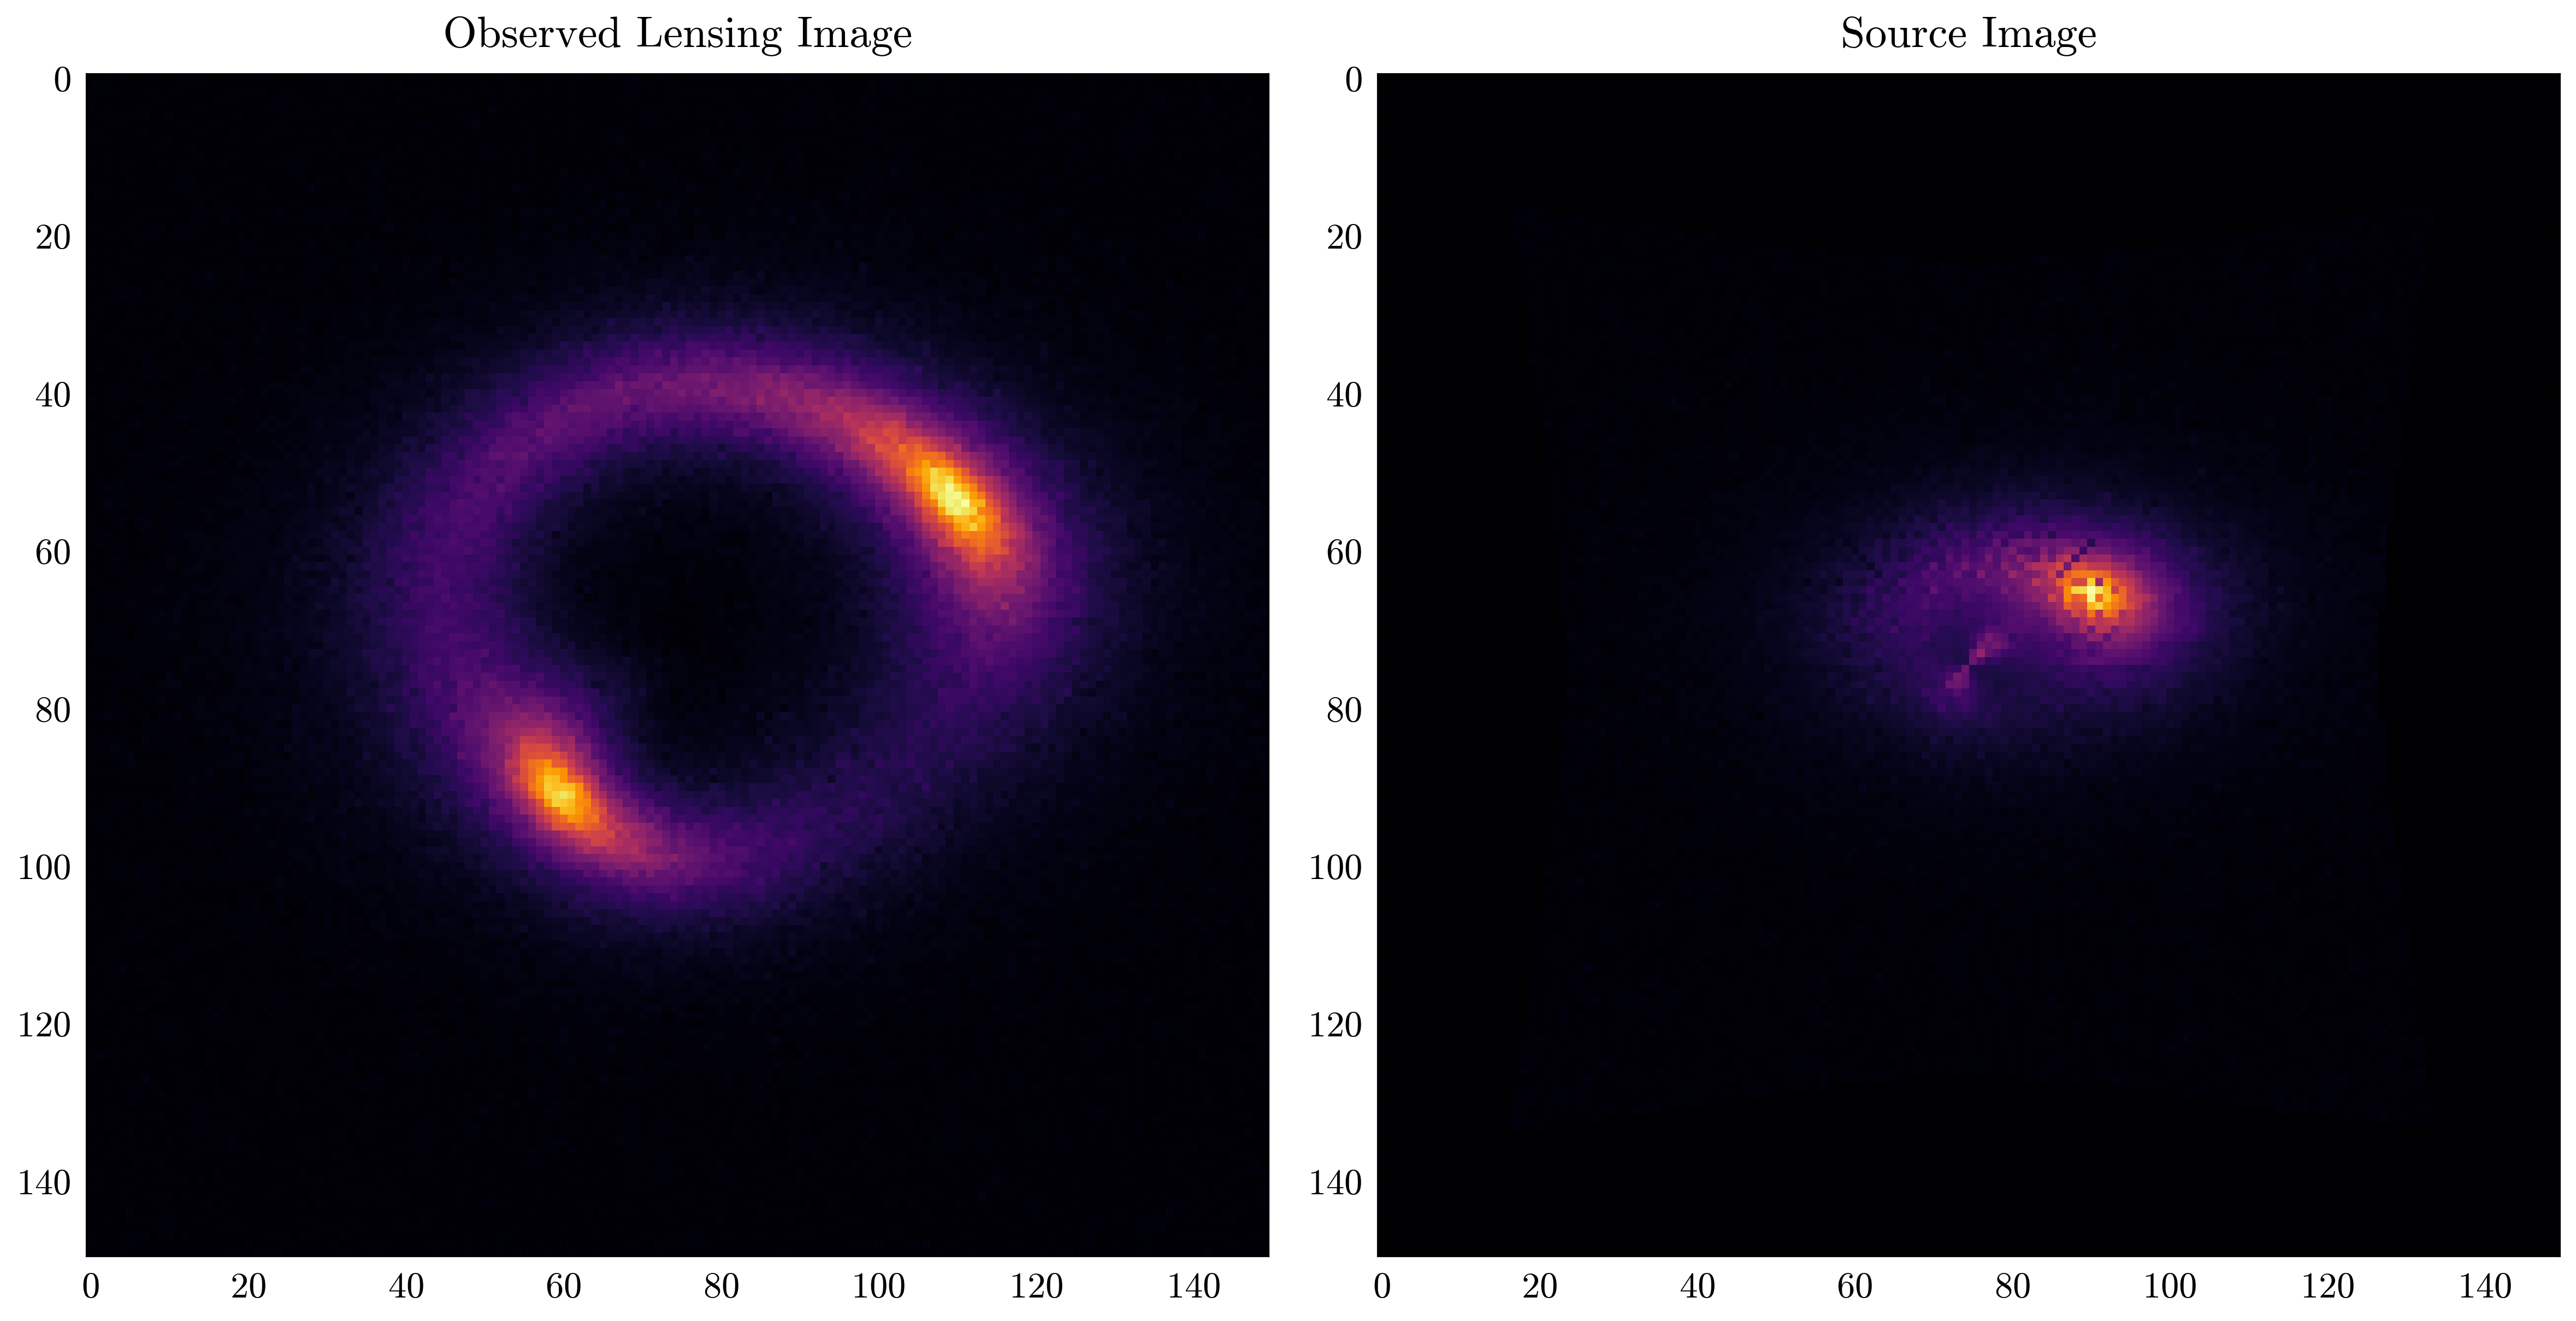

In [45]:
image = np.load("/root/DeepLense/dataset/train/no/1.npy", allow_pickle=True)[0]
phy = Physics()
source = phy.image_to_source(image, E_r=1)
print(image.shape)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(image, cmap="inferno")
axs[0].set_title("Observed Lensing Image")
axs[1].imshow(source, cmap="inferno")
axs[1].set_title("Source Image")
plt.tight_layout()
plt.show()

# Encoder

In [46]:
class PhysicsInformedEncoder(nn.Module):
    def __init__(self, image_size, patch_size, embedding_dim, num_patches, num_heads,
                 hidden_dim, transformer_block_activation_function, num_transformer_block,
                 device: torch.device, k_max, k_min, num_hidden_layer=1, dropout=0.1, pixel_scale=0.101,
                 min_angle=-3.323, max_angle=3.232, mag=1):
        super().__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_patches = num_patches
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.k_max = k_max
        self.k_min = k_min
        self.transformer_block_activation_function = transformer_block_activation_function
        self.num_transformer_block = num_transformer_block
        self.device = device
        self.dropout = dropout
        self.pixel_scale = pixel_scale
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.source_mag = mag

        self.transformer = nn.ModuleList()

        for _ in range(self.num_transformer_block):
            self.transformer.append(
                TransformerLSABlock(embedding_dim=self.embedding_dim,
                                    num_head=self.num_heads,
                                    num_patches=self.num_patches,
                                    num_hidden_neurons=self.hidden_dim,
                                    num_hidden_layers=num_hidden_layer,
                                    activation_function=self.transformer_block_activation_function,
                                    device=self.device,
                                    dropout=dropout)
            )

        # Adding a compressor to give us the deflection angle for each pixel
        self.transformer.append(nn.Flatten())
        self.total_features = (self.num_patches + 1) * self.embedding_dim
        self.transformer.append(nn.Linear(self.total_features, self.image_size*self.image_size))
        self.physics = Physics(mag=1)
        self.imones = torch.ones((self.image_size,self.image_size)).to(self.device)
        self.imones_1d = torch.ones((self.image_size*self.image_size)).to(self.device)
        # Create a grid for image coordinates
        self.profile_size = self.image_size
        self.half_profile_size = self.profile_size // 2

    def image_to_source(self, image, centre=None, E_r=None, deflection=None, gradient=None):
        length, width = image.shape
        pixel_width = (self.max_angle - self.min_angle) / length
        if centre is None:
            centre = (length // 2, width // 2)
        centre_x, centre_y = centre
        if False:
            centre_x = centre_x.item()
            centre_y = centre_y.item()
        
        range_indices_x = torch.arange(-(centre_x - 1), length - (centre_x - 1), device=self.device)
        range_indices_y = torch.arange(-(centre_y - 1), width - (centre_y - 1), device=self.device)

        x, y = torch.meshgrid(range_indices_x, range_indices_y, indexing='ij')
        x, y = x * pixel_width, y * pixel_width

        r = torch.sqrt(x**2 + y**2)
        mask = (r == 0)
        r[mask] = 1

        if deflection is not None:
            if deflection.shape != (length, width):
                raise ValueError(f"The deflection should be of shape (2, {length}, {width}) but got {deflection.shape}")
            xdef = (deflection * x) / r
            ydef = (deflection * y) / r
        elif gradient is not None:
            if gradient.shape != image.shape:
                raise ValueError("The gradient and image should be of the same shape")
            xdef = np.gradient(gradient, axis=0)
            ydef = np.gradient(gradient, axis=1)
        elif E_r is not None:
            k = torch.ones((length, width), device=self.device) * E_r
            xdef = (k * x) / r
            ydef = (k * y) / r
        else:
            raise ValueError("Both deflection and gradient cannot be None")

        bx = x - xdef
        by = y - ydef

        bx, by = bx / pixel_width, by / pixel_width

        bx = torch.clamp(bx + centre_x * self.source_mag, 0, length * self.source_mag - 1).long()
        by = torch.clamp(by + centre_y * self.source_mag, 0, width * self.source_mag - 1).long()

        # Initialize the output image tensor
        sourceimage = torch.zeros((length * self.source_mag, width * self.source_mag), dtype=torch.float, device=self.device)
        
        # Flatten the image and coordinates
        flat_image = image.view(-1)
        flat_bx = bx.view(-1)
        flat_by = by.view(-1)

        # Calculate 1D indices
        one_d_indices = flat_bx * (width * self.source_mag) + flat_by

        # Scatter add the values to sourceimage
        sourceimage_flat = sourceimage.view(-1)
        count  = torch.zeros_like(sourceimage_flat)
        sourceimage_flat = sourceimage_flat.scatter_add(0, one_d_indices, flat_image)
        count = count.scatter_add(0, one_d_indices, self.imones_1d)
        mask = count!=0
        sourceimage_flat[mask]/=count[mask]
        sourceimage = sourceimage_flat.view(sourceimage.shape)

        return sourceimage


    def forward(self, input_images, patches,distortion):
        # Move tensors to the appropriate device
        input_images = input_images.to(self.device)
        distortion = distortion.to(self.device)
        patches = patches.to(self.device)

        batch_size = input_images.shape[0]

        # Process patches through transformer layers
        k_sigmoid = patches
        for layer in self.transformer:
            k_sigmoid = layer(k_sigmoid)

        # Extract output components from k_sigmoid
        k_sigmoid = k_sigmoid.view(batch_size,64,64)
        distortion = distortion.view(batch_size,64,64)
        einstein_angle = k_sigmoid*distortion

        # Reshape input images
        input_images = input_images.view(batch_size, self.image_size, self.image_size)

        # Initialize source_image tensor
        source_image = torch.zeros_like(input_images)

        # Transform each image in the batch
        for i in range(batch_size):
            source_image_np = self.image_to_source(image=input_images[i], E_r=einstein_angle[i])
            source_image[i] = source_image_np

        return k_sigmoid,source_image

In [47]:
phy = PhysicsInformedEncoder(image_size=64, 
                             patch_size=32, 
                             embedding_dim = 384, 
                             num_patches = 4, 
                             num_heads=8,
                             hidden_dim=64, 
                             transformer_block_activation_function=nn.ReLU, 
                             num_transformer_block = 2,
                             device = "cuda", 
                             k_max = 1.2, 
                             k_min = 0.8).to("cuda")

In [48]:
tokenizer = ShiftPatchTokenizer(image_size=64, embedding_size=384, patch_size=32, num_channels=1, translation_mode="rectangular", device="cpu")
input_tensor = torch.randn(64, 1, 64, 64)  
output = tokenizer(input_tensor)
print(output.shape)  

torch.Size([64, 5, 384])


# PhysicsInformedResNet18

In [49]:
import torch.nn.functional as F2

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        out = F2.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return F2.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3, source_mag=1, min_angle = -3.232, max_angle = 3.232):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # grayscale input
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        #Physics
        self.source_mag = source_mag
        self.min_angle = min_angle
        self.max_angle = max_angle

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def preprocess(self, image):
        # image: [B, H, W]
        imax = image.view(image.size(0), -1).max(dim=1)[0]
        log_squared = torch.square(torch.log(imax[:, None, None] / (image + 1e-8)))
        # Gradient along H (dim=1)
        grad_y = torch.zeros_like(image)
        grad_y[:, 1:-1, :] = (log_squared[:, 2:, :] - log_squared[:, :-2, :]) / 2
        grad_y[:, 0, :] = log_squared[:, 1, :] - log_squared[:, 0, :]
        grad_y[:, -1, :] = log_squared[:, -1, :] - log_squared[:, -2, :]
        # Gradient along W (dim=2)
        grad_xy = torch.zeros_like(image)
        grad_xy[:, :, 1:-1] = (grad_y[:, :, 2:] - grad_y[:, :, :-2]) / 2
        grad_xy[:, :, 0] = grad_y[:, :, 1] - grad_y[:, :, 0]
        grad_xy[:, :, -1] = grad_y[:, :, -1] - grad_y[:, :, -2]
        return torch.abs(torch.tanh(grad_xy))
    
    def forward(self, x):
        
        centre=None
        E_r=1
        deflection=None
        gradient=None
        
        # Extract batch dimensions
        batch_size, _, height, width = x.shape  # x is [B, 1, 150, 150]
        device = x.device
        length = height  # 150
        pixel_width = (self.max_angle - self.min_angle) / length
    
        # Extract image data from input tensor
        image = x[:, 0, :, :]  # [B, 150, 150]
    
        # Set default centre if not provided
        if centre is None:
            centre = (length // 2, width // 2)
        centre_x, centre_y = centre
    
        # Create coordinate grids in angle units (same for all batch elements)
        range_indices_x = torch.arange(-(centre_x - 1), length - (centre_x - 1), device=device)
        range_indices_y = torch.arange(-(centre_y - 1), width - (centre_y - 1), device=device)
        x_grid, y_grid = torch.meshgrid(range_indices_x, range_indices_y, indexing='ij')
        x_grid, y_grid = x_grid * pixel_width, y_grid * pixel_width  # [150, 150]
    
        # Compute radial distance and handle zero values
        r = torch.sqrt(x_grid**2 + y_grid**2)  # [150, 150]
        r = torch.where(r == 0, torch.tensor(1.0, device=device), r)
    
        # Compute deflection components based on provided input
        if deflection is not None:
            if deflection.shape != (batch_size, length, width):
                raise ValueError(f"deflection should be of shape ({batch_size}, {length}, {width})")
            xdef = (deflection * x_grid) / r  # [B, 150, 150] * [150, 150] / [150, 150]
            ydef = (deflection * y_grid) / r
        elif gradient is not None:
            if gradient.shape != (batch_size, length, width):
                raise ValueError(f"gradient should be of shape ({batch_size}, {length}, {width})")
            # Compute gradients using finite differences
            xdef = torch.zeros_like(gradient)  # [B, 150, 150]
            xdef[:, 1:-1, :] = (gradient[:, 2:, :] - gradient[:, :-2, :]) / 2
            xdef[:, 0, :] = gradient[:, 1, :] - gradient[:, 0, :]
            xdef[:, -1, :] = gradient[:, -1, :] - gradient[:, -2, :]
            ydef = torch.zeros_like(gradient)
            ydef[:, :, 1:-1] = (gradient[:, :, 2:] - gradient[:, :, :-2]) / 2
            ydef[:, :, 0] = gradient[:, :, 1] - gradient[:, :, 0]
            ydef[:, :, -1] = gradient[:, :, -1] - gradient[:, :, -2]
        elif E_r is not None:
            if isinstance(E_r, (int, float)):
                k = torch.full((batch_size, length, width), E_r, device=device)
            elif E_r.shape == (batch_size,):
                k = E_r.view(-1, 1, 1) * torch.ones((batch_size, length, width), device=device)
            else:
                raise ValueError("E_r should be a scalar or a tensor of shape (B,)")
            xdef = (k * x_grid) / r  # [B, 150, 150] * [150, 150] / [150, 150]
            ydef = (k * y_grid) / r
        else:
            raise ValueError("One of deflection, gradient, or E_r must be provided")
    
        # Compute source plane positions in angle units
        bx = x_grid - xdef  # [150, 150] - [B, 150, 150] -> [B, 150, 150]
        by = y_grid - ydef
    
        # Convert to pixel indices in the source plane
        bx_pixels = bx / pixel_width
        by_pixels = by / pixel_width
        source_length = int(length * self.source_mag)
        source_width = int(width * self.source_mag)
        bx_idx = (bx_pixels + centre_x * self.source_mag).clamp(0, source_length - 1).to(torch.int64)
        by_idx = (by_pixels + centre_y * self.source_mag).clamp(0, source_width - 1).to(torch.int64)
    
        # Initialize source image and counts tensors for the batch
        global_sourceimage = torch.zeros(batch_size * source_length * source_width, device=device)
        global_counts = torch.zeros(batch_size * source_length * source_width, device=device, dtype=torch.int64)
    
        # Compute global flat indices for scattering
        batch_offset = torch.arange(batch_size, device=device) * (source_length * source_width)
        flat_idx_global = (batch_offset.view(-1, 1, 1) + (bx_idx * source_width + by_idx)).view(-1)
        flat_image = image.view(-1)  # [B * 150 * 150]
        ones = torch.ones_like(flat_image, dtype=torch.int64)
    
        # Accumulate using scatter_add_
        global_sourceimage.scatter_add_(0, flat_idx_global, flat_image)
        global_counts.scatter_add_(0, flat_idx_global, ones)
    
        # Reshape back to batched format
        sourceimage = global_sourceimage.view(batch_size, source_length, source_width)
        counts = global_counts.view(batch_size, source_length, source_width)
    
        # Average source image where counts > 0
        average_mask = counts > 0
        sourceimage[average_mask] = sourceimage[average_mask] / counts[average_mask].float()

        # Generate pre-processing
        image = x[:, 0, :, :]  # [B, 150, 150]
        preproc_image = self.preprocess(image)  # [B, 150, 150]
        
        # Prepare for concatenation
        source_images = sourceimage.unsqueeze(1)  # [B, 1, 150, 150]
        preproc_images = preproc_image.unsqueeze(1)  # [B, 1, 150, 150]
        x = torch.cat((x, source_images, preproc_images), dim=1)  # [B, 3, 150, 150]
    
        # Proceed with the rest of the network
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def PhysicsInformedResNet18(num_classes=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)




# Train

In [50]:
def count_parameters(model: nn.Module) -> float:
    num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_parameters_m = num_parameters / 1e6
    print(f"The model has {num_parameters_m:.2f}M trainable parameters.")
    return num_parameters_m

def save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler, train_loss, val_loss, val_acc):
    """Saves a checkpoint with the model, optimizer, scheduler, and training metrics."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
    }, checkpoint_path)
    print(f"Saved checkpoint to {checkpoint_path}")

def train_model(model, train_loader, val_loader, n_epochs, optimizer, scheduler, criterion, device, checkpoint_dir, epochloss_dir, checkpoint_interval=5, load_model=False):
    best_val_acc = 0.0
    best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
    
    # Load best model if exists
    if os.path.exists(best_model_path) and load_model:
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        best_val_acc = checkpoint['val_accuracy']
        print(f"Loaded best model with Val Accuracy: {best_val_acc:.2f}%")
    else:
        print("Starting from scratch.")
    
    metrics = {
        'train_loss': [], 
        'val_loss': [], 
        'val_acc': []
    }

    epochloss_path = os.path.join(epochloss_dir, "val_loss.txt")

    for epoch in range(n_epochs):
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        metrics['train_loss'].append(avg_train_loss)
        metrics['val_loss'].append(avg_val_loss)
        metrics['val_acc'].append(val_acc)

        # Save validation loss to file
        with open(epochloss_path, "a") as f:
            f.write(f"{epoch+1},{avg_val_loss:.4f}\n")

        # Update the learning rate
        # scheduler.step()
        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{n_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]}")

        # Save a checkpoint at the specified interval
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
            save_checkpoint(checkpoint_path, epoch + 1, model, optimizer, scheduler, avg_train_loss, avg_val_loss, val_acc)

        # Save the best model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(best_model_path, epoch + 1, model, optimizer, scheduler, avg_train_loss, avg_val_loss, val_acc)
            print(f"New best model saved with Val Accuracy: {val_acc:.2f}%")
    
    return metrics


def evaluate_roc(model, test_loader, device, num_classes=3):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Binarize labels for ROC
    y_test = label_binarize(all_labels, classes=range(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    # Compute ROC curve and AUC for each class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green']
    class_names = ['no', 'sphere', 'vort']
    
    for i, color in enumerate(colors[:num_classes]):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Test Data')
    plt.legend(loc="lower right")
    plt.show()

    return all_labels, all_preds, roc_auc

In [51]:
# physics_encoder = PhysicsInformedEncoder(image_size=64, 
#                              patch_size=32, 
#                              embedding_dim = 384, 
#                              num_patches = 4, 
#                              num_heads=8,
#                              hidden_dim=64, 
#                              transformer_block_activation_function=nn.ReLU, 
#                              num_transformer_block = 2,
#                              device = "cuda", 
#                              k_max = 1.2, 
#                              k_min = 0.8).to("cuda")

In [52]:
device = torch.device("cuda")
# # Instantiate combined model
model = PhysicsInformedResNet18()

# # Example input image
# input_image = torch.randn(64, 1, 64, 64)  # Batch of 64 grayscale images of size 64x64

# # Forward pass
# output = model(input_image)

# print(output.shape)  # Output shape depends on your final architecture (e.g., [64, 512, 5, 5] after fusion)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [53]:
# Define loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [54]:
# Count model parameters
num_parameters = count_parameters(model)

# Train the model (using test_loader as validation for this example)
metrics = train_model(
    model, train_loader, test_loader,
    n_epochs=400, optimizer=optimizer, scheduler=scheduler,
    criterion=criterion, device=device, checkpoint_dir=checkpoint_dir,
    checkpoint_interval=100, epochloss_dir=epochloss_dir, load_model=False
)

The model has 11.18M trainable parameters.
Starting from scratch.
Epoch [1/400]
Train Loss: 1.1257, Train Acc: 33.07%
Val Loss: 1.1091, Val Acc: 31.07%
Learning Rate: 0.006
Saved checkpoint to /workspace_2/checkpoint/best_model.pth
New best model saved with Val Accuracy: 31.07%
Epoch [2/400]
Train Loss: 1.0999, Train Acc: 33.46%
Val Loss: 1.0987, Val Acc: 31.13%
Learning Rate: 0.006
Saved checkpoint to /workspace_2/checkpoint/best_model.pth
New best model saved with Val Accuracy: 31.13%
Epoch [3/400]
Train Loss: 1.0991, Train Acc: 33.36%
Val Loss: 1.0975, Val Acc: 35.30%
Learning Rate: 0.006
Saved checkpoint to /workspace_2/checkpoint/best_model.pth
New best model saved with Val Accuracy: 35.30%
Epoch [4/400]
Train Loss: 1.0996, Train Acc: 32.96%
Val Loss: 1.0987, Val Acc: 33.93%
Learning Rate: 0.006
Epoch [5/400]
Train Loss: 1.0995, Train Acc: 32.90%
Val Loss: 1.0992, Val Acc: 33.73%
Learning Rate: 0.006
Epoch [6/400]
Train Loss: 1.0991, Train Acc: 32.94%
Val Loss: 1.0992, Val Acc: 31

KeyboardInterrupt: 

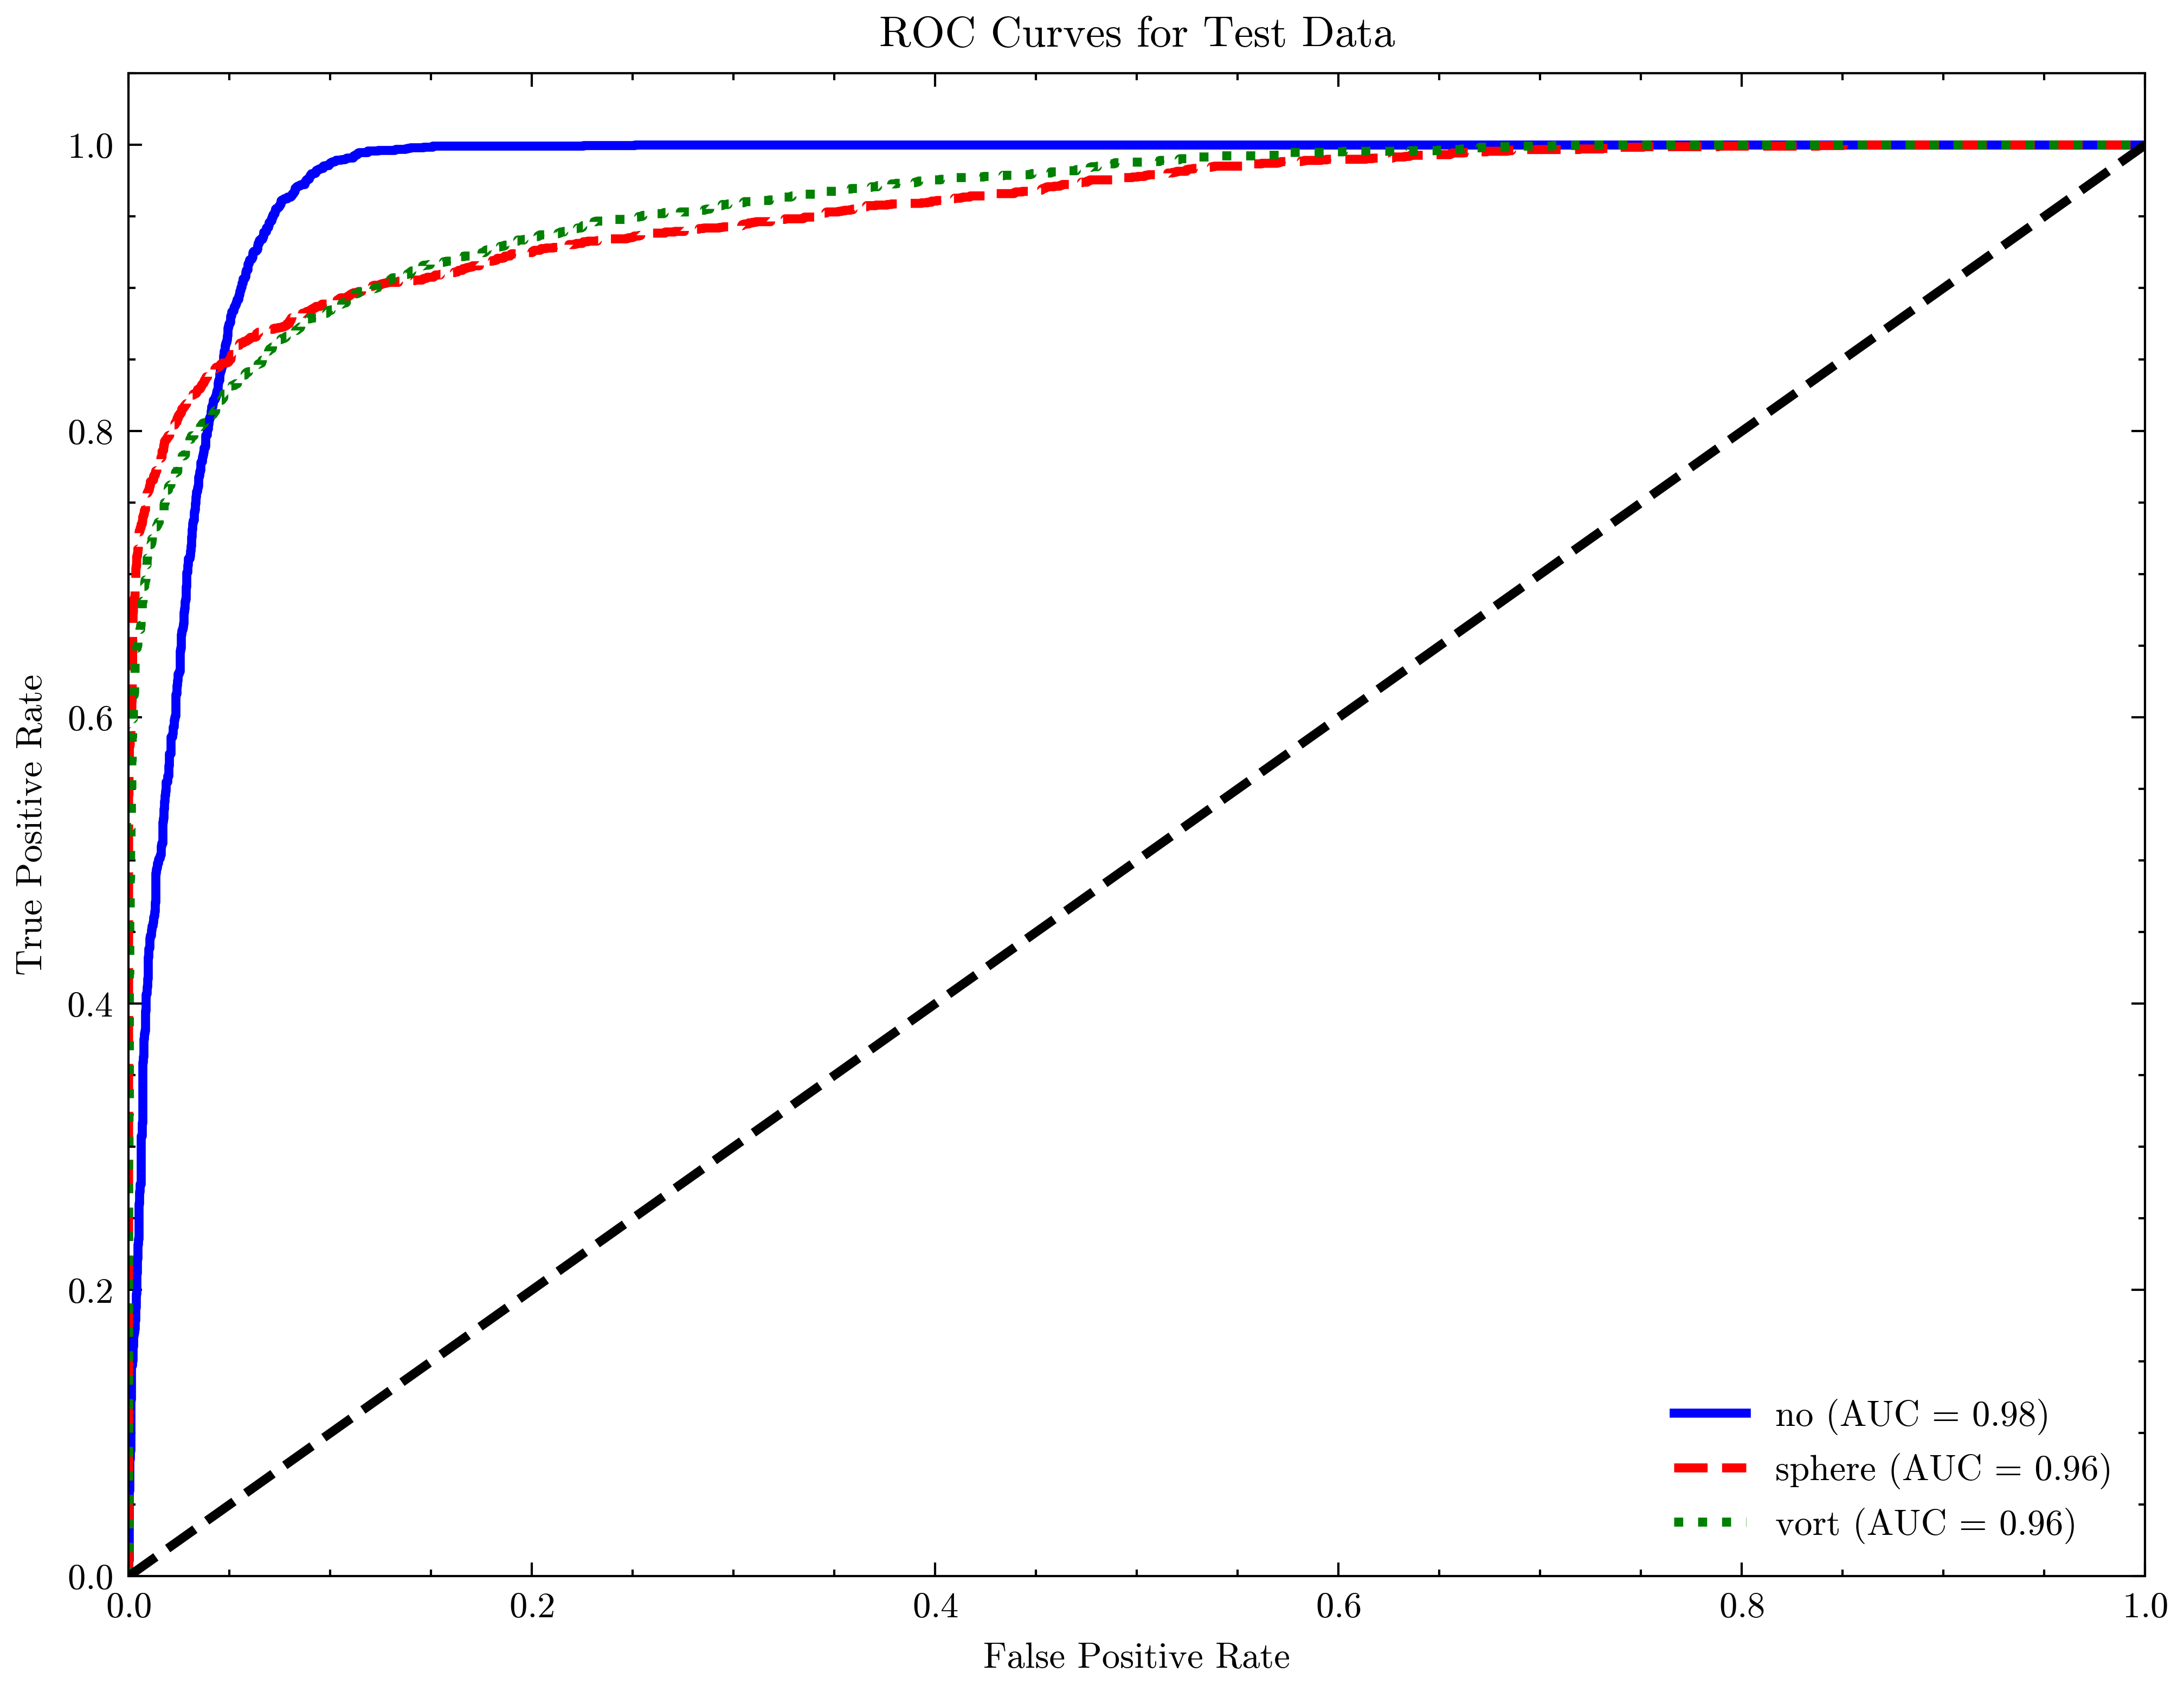

Saved final model to /workspace_2/checkpoint/final_model.pth


In [55]:
# Evaluate ROC using test_loader (since final_test_loader is not used)
y_true, y_pred_prob, roc_auc = evaluate_roc(model, test_loader, device)

# Save the final model weights (using a path similar to the reference code)
final_model_path = os.path.join(checkpoint_dir, "final_model.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Saved final model to {final_model_path}")